### this script is trying to apply VAE to session-wise functional connectivity patterns

* functional connectivity patterns are derived from AAL atlas with 170 ROIs
* FC is calculated among 170 AAL ROIs (170*170 matrix) with NAN values


In [96]:
import numpy as np
from scipy.io import loadmat
import nibabel as nib
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [134]:
from sklearn import datasets, svm
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold

In [133]:
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [10]:
# Load subject info
SubInfo = pd.read_excel('/Users/liuq13/NODEAP_scripts/ProcessedData/SubConds.xlsx')
Subs = SubInfo[SubInfo['Include'] == 1]['SubID']

In [19]:
Subs

0     NODEAP_06
1     NODEAP_07
2     NODEAP_08
3     NODEAP_09
4     NODEAP_10
5     NODEAP_12
6     NODEAP_13
7     NODEAP_15
8     NODEAP_16
9     NODEAP_17
10    NODEAP_24
11    NODEAP_26
12    NODEAP_30
13    NODEAP_34
14    NODEAP_35
15    NODEAP_36
16    NODEAP_39
17    NODEAP_41
18    NODEAP_43
19    NODEAP_44
20    NODEAP_45
21    NODEAP_46
22    NODEAP_48
23    NODEAP_51
24    NODEAP_53
25    NODEAP_55
26    NODEAP_56
27    NODEAP_59
28    NODEAP_60
29    NODEAP_63
30    NODEAP_64
31    NODEAP_65
32    NODEAP_66
33    NODEAP_68
34    NODEAP_70
35    NODEAP_73
36    NODEAP_74
37    NODEAP_76
38    NODEAP_77
39    NODEAP_78
40    NODEAP_79
41    NODEAP_80
42    NODEAP_83
43    NODEAP_84
44    NODEAP_85
45    NODEAP_86
46    NODEAP_87
47    NODEAP_88
Name: SubID, dtype: object

In [11]:
SubInfo

,SubID,Gender,Birth.Year,StimLoc,StimOrder,Odors,StartOdor,Age,Sex,Include,btS1,btS2,btS3,btS1S2,btS2S3
0,NODEAP_06,Male,1992,Posterior,321,"Chocolate, Garlic",Sweet,30.83,M,1,1,1,1,13,15
1,NODEAP_07,Female,1991,Anterior,312,"Pineapple, Pizza",Savory,32.01,F,1,1,1,1,20,13
2,NODEAP_08,Male,1996,Posterior,132,"Chocolate, Garlic",Sweet,26.19,M,1,1,1,1,12,14
3,NODEAP_09,Female,2000,Posterior,321,"Gingerbread, Garlic",Savory,22.32,F,1,1,1,1,14,27
4,NODEAP_10,Male,1999,Posterior,321,"Chocolate, Garlic",Savory,23.62,M,1,1,1,1,13,12
5,NODEAP_12,Female,2002,Anterior,123,"Pineapple, Potato",Savory,20.89,F,1,1,1,1,19,27
6,NODEAP_13,Female,1990,Anterior,231,"Yellow, Garlic",Sweet,33.00,F,1,1,1,1,11,14
7,NODEAP_15,Female,1996,Posterior,231,"Gingerbread, Pizza",Sweet,26.62,F,1,1,1,1,13,21
8,NODEAP_16,Female,2000,Posterior,231,"Chocolate, Potato",Savory,22.37,F,1,1,1,1,13,34
9,NODEAP_17,Female,1996,Posterior,213,"Gingerbread, Garlic",Savory,26.39,F,1,1,1,1,13,27


In [12]:
SubInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SubID       48 non-null     object 
 1   Gender      48 non-null     object 
 2   Birth.Year  48 non-null     int64  
 3   StimLoc     48 non-null     object 
 4   StimOrder   48 non-null     int64  
 5   Odors       48 non-null     object 
 6   StartOdor   48 non-null     object 
 7   Age         48 non-null     float64
 8   Sex         48 non-null     object 
 9   Include     48 non-null     int64  
 10  btS1        48 non-null     int64  
 11  btS2        48 non-null     int64  
 12  btS3        48 non-null     int64  
 13  btS1S2      48 non-null     int64  
 14  btS2S3      48 non-null     int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 5.8+ KB


In [13]:
TMS_types = []

# Loop through each row and assign TMS types based on 'StimOrder'
for i, row in SubInfo.iterrows():
    tmp_order = row['StimOrder']
    
    # Assign TMS types based on the 'StimOrder' value
    if tmp_order == 123:
        TMS_types.append(['N', 'C', 'S', 'S', 'C', 'S', 'S'])
    elif tmp_order == 132:
        TMS_types.append(['N', 'C', 'S', 'S', 'S', 'S', 'C'])
    elif tmp_order == 213:
        TMS_types.append(['N', 'S', 'C', 'C', 'S', 'S', 'S'])
    elif tmp_order == 231:
        TMS_types.append(['N', 'S', 'C', 'S', 'S', 'C', 'S'])
    elif tmp_order == 312:
        TMS_types.append(['N', 'S', 'S', 'C', 'S', 'S', 'C'])
    elif tmp_order == 321:
        TMS_types.append(['N', 'S', 'S', 'S', 'C', 'C', 'S'])

In [16]:
TMS_types

[['N', 'S', 'S', 'S', 'C', 'C', 'S'],
 ['N', 'S', 'S', 'C', 'S', 'S', 'C'],
 ['N', 'C', 'S', 'S', 'S', 'S', 'C'],
 ['N', 'S', 'S', 'S', 'C', 'C', 'S'],
 ['N', 'S', 'S', 'S', 'C', 'C', 'S'],
 ['N', 'C', 'S', 'S', 'C', 'S', 'S'],
 ['N', 'S', 'C', 'S', 'S', 'C', 'S'],
 ['N', 'S', 'C', 'S', 'S', 'C', 'S'],
 ['N', 'S', 'C', 'S', 'S', 'C', 'S'],
 ['N', 'S', 'C', 'C', 'S', 'S', 'S'],
 ['N', 'S', 'S', 'S', 'C', 'C', 'S'],
 ['N', 'S', 'C', 'C', 'S', 'S', 'S'],
 ['N', 'S', 'C', 'C', 'S', 'S', 'S'],
 ['N', 'C', 'S', 'S', 'S', 'S', 'C'],
 ['N', 'C', 'S', 'S', 'C', 'S', 'S'],
 ['N', 'C', 'S', 'S', 'C', 'S', 'S'],
 ['N', 'S', 'S', 'S', 'C', 'C', 'S'],
 ['N', 'S', 'C', 'C', 'S', 'S', 'S'],
 ['N', 'C', 'S', 'S', 'C', 'S', 'S'],
 ['N', 'C', 'S', 'S', 'C', 'S', 'S'],
 ['N', 'S', 'S', 'C', 'S', 'S', 'C'],
 ['N', 'S', 'C', 'C', 'S', 'S', 'S'],
 ['N', 'C', 'S', 'S', 'C', 'S', 'S'],
 ['N', 'S', 'S', 'S', 'C', 'C', 'S'],
 ['N', 'S', 'C', 'S', 'S', 'C', 'S'],
 ['N', 'S', 'S', 'C', 'S', 'S', 'C'],
 ['N', 'S', 

In [17]:
base_nifti_folder = '/Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID'
sessions = ['D0', 'S1D1', 'S1D2', 'S2D1', 'S2D2', 'S3D1', 'S3D2']
nifti_paths_by_tms_type = {'N': [], 'C': [], 'S': []}

In [18]:
nifti_paths_by_tms_type

{'N': [], 'C': [], 'S': []}

In [24]:
def vectorize_fc(fc_mat):
    # Upper triangle, excluding diagonal
    return fc_mat[np.triu_indices(fc_mat.shape[0], k=1)]

In [27]:
all_corr_data = []
all_tms_type = []
all_subject_id = []

for i, subject_id in enumerate(Subs):
    tms_types = TMS_types[i]  
    for j, session in enumerate(sessions):
        mat_name = 'conn_matrix_' + session + '.mat'
        mat_file = os.path.join(base_nifti_folder, subject_id, mat_name)
        if os.path.exists(mat_file):
            matdat = loadmat(mat_file)
            dat_corr = matdat['correlation_matrix']  
            dat_vec = vectorize_fc(dat_corr)  # <- vectorized
            all_corr_data.append(dat_vec)
            all_tms_type.append(tms_types[j])  # keep condition label
            all_subject_id.append(subject_id)
        else:
            print(f"matfile not found: {mat_file}")

matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_30/conn_matrix_S3D2.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_44/conn_matrix_S1D1.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_83/conn_matrix_S3D1.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_87/conn_matrix_D0.mat
matfile not found: /Volumes/X9Pro/NODEAP/FuncConn_AAL_PAID/NODEAP_88/conn_matrix_D0.mat


In [23]:
dat_corr.shape

(170, 170)

In [28]:
dat_vec.shape

(14365,)

In [103]:
# Map 'N' = 0 (Null), 'S' = 1 (Sham), 'C' = 2 (Real/cTBS)
label_map = {'N': 0, 'S': 1, 'C': 2}
y = np.array([label_map[t] for t in all_tms_type])

In [107]:
y.shape

(331,)

In [106]:
X = np.array(all_corr_data)  # shape: (num_sessions, 14365)
X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)  # Standardize per feature
X.shape

(331, 14365)

In [82]:
print("Any NaN in X?", np.isnan(X).any())

Any NaN in X? True


In [84]:
nan_cols = np.isnan(X).any(axis=0)
print(f"Columns with NaN: {nan_cols.sum()} / {X.shape[1]}")
X_clean = X[:, ~nan_cols]

print("X_clean shape:", X_clean.shape)
print("Any NaNs in X_clean?", np.isnan(X_clean).any())


Columns with NaN: 999 / 14365
X_clean shape: (331, 13366)
Any NaNs in X_clean? False


In [86]:
X = X_clean

In [87]:
input_dim = X.shape[1]  # e.g., 14365
latent_dim = 10

In [88]:
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [142]:
# define VAE functions

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2_mu = nn.Linear(256, latent_dim)
        self.fc2_logvar = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Prevent NaNs
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return self.fc4(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # also mean here
    return recon_loss + kld


In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [144]:
# Training loop
for epoch in range(50):
    total_loss = 0
    for (batch,) in dataloader:
        batch = batch.to(device)
        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Loss {total_loss:.2f}")

Epoch 0: Loss 12.06
Epoch 1: Loss 12.06
Epoch 2: Loss 11.91
Epoch 3: Loss 11.68
Epoch 4: Loss 11.58
Epoch 5: Loss 11.57
Epoch 6: Loss 11.45
Epoch 7: Loss 11.43
Epoch 8: Loss 11.44
Epoch 9: Loss 11.44
Epoch 10: Loss 11.42
Epoch 11: Loss 11.37
Epoch 12: Loss 11.44
Epoch 13: Loss 11.35
Epoch 14: Loss 11.38
Epoch 15: Loss 11.34
Epoch 16: Loss 11.23
Epoch 17: Loss 11.31
Epoch 18: Loss 11.21
Epoch 19: Loss 11.24
Epoch 20: Loss 11.21
Epoch 21: Loss 11.22
Epoch 22: Loss 11.25
Epoch 23: Loss 11.23
Epoch 24: Loss 11.21
Epoch 25: Loss 11.25
Epoch 26: Loss 11.22
Epoch 27: Loss 11.30
Epoch 28: Loss 11.23
Epoch 29: Loss 11.20
Epoch 30: Loss 11.20
Epoch 31: Loss 11.14
Epoch 32: Loss 11.16
Epoch 33: Loss 11.11
Epoch 34: Loss 11.16
Epoch 35: Loss 11.29
Epoch 36: Loss 11.29
Epoch 37: Loss 11.20
Epoch 38: Loss 11.15
Epoch 39: Loss 11.10
Epoch 40: Loss 11.25
Epoch 41: Loss 11.19
Epoch 42: Loss 11.24
Epoch 43: Loss 11.15
Epoch 44: Loss 11.17
Epoch 45: Loss 11.13
Epoch 46: Loss 11.21
Epoch 47: Loss 11.09
Ep

In [91]:
model.eval()
with torch.no_grad():
    mu_all = []
    for i in range(X.shape[0]):
        x = torch.tensor(X[i], dtype=torch.float32).to(device).unsqueeze(0)
        mu, _ = model.encode(x)
        mu_all.append(mu.cpu().numpy().flatten())
mu_all = np.array(mu_all)


In [93]:
mu_all.shape

(331, 10)

In [136]:
real_idx = (y == 2)
sham_idx = (y == 1)

mu_real = mu_all[real_idx]
mu_sham = mu_all[sham_idx]

from scipy.stats import ttest_ind

for i in range(mu_all.shape[1]):
    t, p = ttest_ind(mu_real[:, i], mu_sham[:, i])
    print(f"Latent dim {i}: p = {p:.3g}")


Latent dim 0: p = 0.989
Latent dim 1: p = 0.401
Latent dim 2: p = 0.584
Latent dim 3: p = 0.418
Latent dim 4: p = 0.802
Latent dim 5: p = 0.965
Latent dim 6: p = 0.907
Latent dim 7: p = 0.966
Latent dim 8: p = 0.516
Latent dim 9: p = 0.976


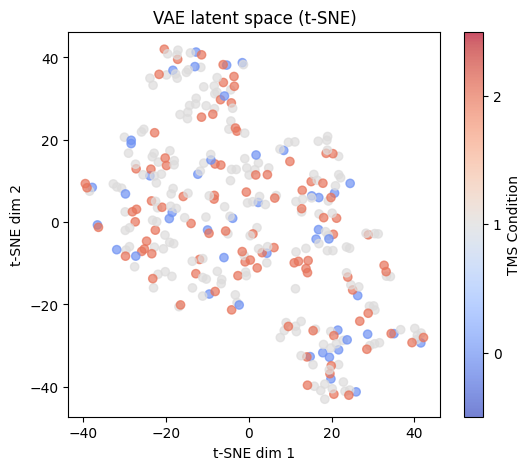

In [137]:
z_2d = TSNE(n_components=2, perplexity=10).fit_transform(mu_all)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("VAE latent space (t-SNE)")
plt.colorbar(scatter, ticks=[0, 1, 2], label='TMS Condition')
plt.clim(-0.5, 2.5)
plt.xlabel('t-SNE dim 1'); plt.ylabel('t-SNE dim 2')
plt.show()

In [138]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=0)
z_umap = reducer.fit_transform(mu_all)

/Users/liuq13/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuq13/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


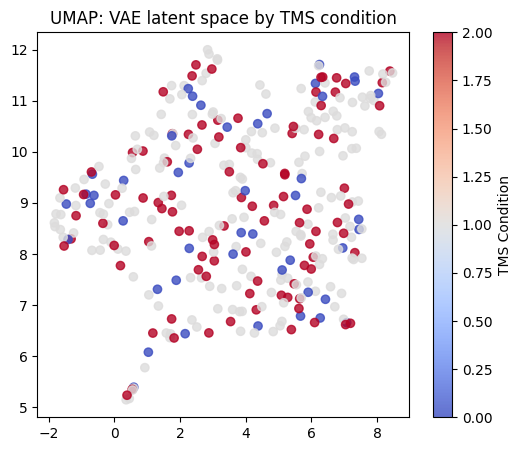

In [139]:
plt.figure(figsize=(6,5))
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=y, cmap='coolwarm', alpha=0.8)
plt.title("UMAP: VAE latent space by TMS condition")
plt.colorbar(label='TMS Condition')
plt.show()

In [141]:
clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, mu_all, y, cv=5)
print("Multiclass accuracy (Null vs Sham vs Real):", scores.mean())


Multiclass accuracy (Null vs Sham vs Real): 0.5740388964269562


In [112]:
mask_C = (y == 2)
mask_S = (y == 1)

X_bin = np.vstack([mu_all[mask_C], mu_all[mask_S]])
y_bin = np.array([1] * mask_C.sum() + [0] * mask_S.sum())

clf = LogisticRegression(max_iter=1000)
scores = cross_val_score(clf, X_bin, y_bin, cv=5)
print("Binary accuracy (Real vs Sham):", scores.mean())


Binary accuracy (Real vs Sham): 0.6666666666666666


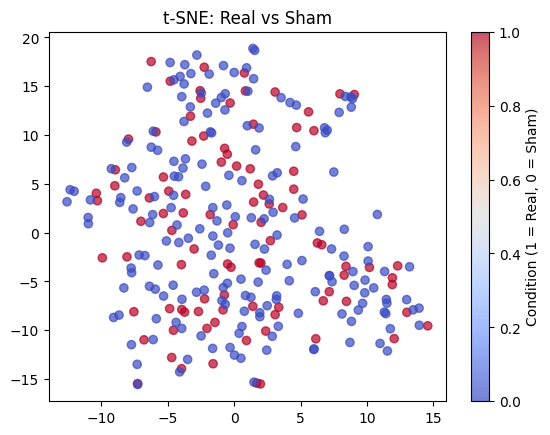

In [131]:
# if only plot real and sham

X_bin = np.vstack([mu_all[y == 2], mu_all[y == 1]])
y_bin = np.array([1] * sum(y == 2) + [0] * sum(y == 1))

z_2d = TSNE(n_components=2).fit_transform(X_bin)

plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_bin, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE: Real vs Sham")
plt.colorbar(label="Condition (1 = Real, 0 = Sham)")
plt.show()


Top discriminative latent dimension: 1 (p = 0.4008)


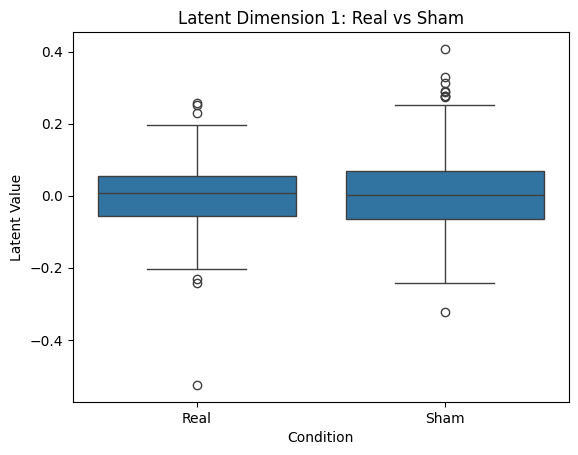

In [130]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np

# Extract only real (2) and sham (1)
real_idx = (y == 2)
sham_idx = (y == 1)

# Get p-values across latent dims
p_values = []
for i in range(mu_all.shape[1]):
    t, p = ttest_ind(mu_all[real_idx, i], mu_all[sham_idx, i])
    p_values.append(p)

# Sort by most discriminative (lowest p-value)
sorted_dims = np.argsort(p_values)
top_dim = sorted_dims[0]
print(f"Top discriminative latent dimension: {top_dim} (p = {p_values[top_dim]:.4g})")

# Prepare data for plotting
values = np.concatenate([mu_all[real_idx, top_dim], mu_all[sham_idx, top_dim]])
labels = ['Real'] * sum(real_idx) + ['Sham'] * sum(sham_idx)

# Plot
df = pd.DataFrame({"Latent Value": values, "Condition": labels})
sns.boxplot(data=df, x="Condition", y="Latent Value")
plt.title(f"Latent Dimension {top_dim}: Real vs Sham")
plt.show()
